In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from LERGfunc import *
%matplotlib inline
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from matplotlib.colors import LogNorm
from astropy import units as u
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance
plt.style.use('ggplot')
from scipy import stats
plt.rcParams['font.family'] = "Serif"

In [2]:
hdu = fits.open('LERG/Spectral Parameters/LERG_model_par.fits')
data = hdu[1].data
compactness=np.array([1,0,0,0,1,0,0,0,1,1,1,0,0,0,1])
compact = data[compactness==0]
extended=data[compactness==1]

In [3]:
amp_OIII5007 = data['amp_OIII5007']
amp_OIII5007_err = data['amp_OIII5007_err']

vel_sigma_OIII = data['vel_sigma_OIII']
vel_sigma_OIII_err = data['vel_sigma_OIII_err']
amp_OIII5007_br = data['amp_OIII5007_br']
amp_OIII5007_br_err = data['amp_OIII5007_br_err']

vel_sigma_OIII_br = data['vel_sigma_OIII_br']
vel_sigma_OIII_br_err = data['vel_sigma_OIII_br_err']

vel_OIII = data['vel_OIII']
vel_OIII_br = data['vel_OIII_br']
vel_OIII_err = data['vel_OIII_err']
vel_OIII_br_err = data['vel_OIII_br_err']

In [4]:
compact_amp_OIII5007 = compact['amp_OIII5007']
compact_vel_sigma_OIII = compact['vel_sigma_OIII']
compact_amp_OIII5007_br = compact['amp_OIII5007_br']
compact_vel_sigma_OIII_br = compact['vel_sigma_OIII_br']
compact_vel_OIII = compact['vel_OIII']
compact_vel_OIII_br = compact['vel_OIII_br']
compact_v_out = compact_vel_OIII_br - compact_vel_OIII
compact_sigma_core = line_width_recons(compact_vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
compact_sigma_wing = line_width_recons(compact_vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)

compact_log_F_OIII = np.log10(compact_amp_OIII5007*(2.*np.pi)*np.fabs(compact_sigma_core))
compact_log_F_OIII_br = np.log10(compact_amp_OIII5007_br*(2.*np.pi)*np.fabs(compact_sigma_wing))

compact_F_core_OIII = 10**compact_log_F_OIII/(10**compact_log_F_OIII+10**compact_log_F_OIII_br)
compact_F_wing_OIII = 10**compact_log_F_OIII_br/(10**compact_log_F_OIII+10**compact_log_F_OIII_br)

compact_fwhm_OIII_tot = 2.354*np.sqrt((compact_F_core_OIII*compact_vel_sigma_OIII)**2+(compact_F_wing_OIII*compact_vel_sigma_OIII_br)**2)


In [5]:
extended_amp_OIII5007 = extended['amp_OIII5007']
extended_vel_sigma_OIII = extended['vel_sigma_OIII']
extended_amp_OIII5007_br = extended['amp_OIII5007_br']
extended_vel_sigma_OIII_br = extended['vel_sigma_OIII_br']
extended_vel_OIII = extended['vel_OIII']
extended_vel_OIII_br = extended['vel_OIII_br']
extended_v_out = extended_vel_OIII_br - extended_vel_OIII
extended_sigma_core = line_width_recons(extended_vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
extended_sigma_wing = line_width_recons(extended_vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)

extended_log_F_OIII = np.log10(extended_amp_OIII5007*(2.*np.pi)*np.fabs(extended_sigma_core))
extended_log_F_OIII_br = np.log10(extended_amp_OIII5007_br*(2.*np.pi)*np.fabs(extended_sigma_wing))

extended_F_core_OIII = 10**extended_log_F_OIII/(10**extended_log_F_OIII+10**extended_log_F_OIII_br)
extended_F_wing_OIII = 10**extended_log_F_OIII_br/(10**extended_log_F_OIII+10**extended_log_F_OIII_br)

extended_fwhm_OIII_tot = 2.354*np.sqrt((extended_F_core_OIII*extended_vel_sigma_OIII)**2+(extended_F_wing_OIII*extended_vel_sigma_OIII_br)**2)
print(extended_F_wing_OIII)

[ 0.76114684  0.56676006  0.28930053  0.18894985  0.44873339  0.24616025]


In [6]:
outflow_speed = np.abs(vel_OIII_br - vel_OIII)
outflow_speed_err = np.sqrt(vel_OIII_br**2 + vel_OIII**2)

In [7]:
sigma_core = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
sigma_wing = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)

log_F_OIII = np.log10(amp_OIII5007*(2.*np.pi)*np.fabs(sigma_core))
log_F_OIII_br = np.log10(amp_OIII5007_br*(2.*np.pi)*np.fabs(sigma_wing))

F_core_OIII = 10**log_F_OIII/(10**log_F_OIII+10**log_F_OIII_br)
F_wing_OIII = 10**log_F_OIII_br/(10**log_F_OIII+10**log_F_OIII_br)

fwhm_OIII_tot = 2.354*np.sqrt((F_core_OIII*vel_sigma_OIII)**2+(F_wing_OIII*vel_sigma_OIII_br)**2)
print(F_wing_OIII)

def edd_ratio(log_L_OIII,vel_sigma_star):
    vel_sigma_ratio = (vel_sigma_star/200)**(4.02)
    const = 2.06*(10**(-43))
    L_OIII = 10**(log_L_OIII)
    edd_rat = (const*L_OIII)/vel_sigma_ratio
    return edd_rat

def M_BH(log_L_OIII,log_r_edd):
    log_k = np.log10(2.06)-43+log_L_OIII
    vel_sigma_ratio = log_k-log_r_edd
    log_MBH=8.13+vel_sigma_ratio
    return log_MBH

[ 0.76114684  0.71064419  0.64859039  0.47777304  0.56676006  0.30869138
  0.53548688  0.50774235  0.28930053  0.18894985  0.44873339  0.23914346
  0.390966    0.51244128  0.24616025]


In [52]:
hdu = fits.open('LERG/Big Table/LERG_spec_par_full.fits')
data = hdu[1].data
Z=data['z']
compactness=np.array([1,0,0,0,1,0,0,0,1,1,1,0,0,0,1])
compact = data[compactness==0]
extended=data[compactness==1]

log_P_jet = data['log_P_jet']
log_P_jet_err = 0.8*np.ones(len(data['log_P_jet']))

log_L_bol = data['log_L_bol']
log_L_bol_err = data['log_L_bol_err']

log_L_OIII_br = data['log_L_OIII_br']
log_L_OIII_br_err = data['log_L_OIII_br_err']

L_OIII_br = 10**log_L_OIII_br

log_L_OIII = log_L_bol - np.log10(3500)
log_L_rad = (log_P_jet - 26.02)/0.75

R_edd = data['r_edd']
R_edd_Mainak = data['r_edd']

extended_log_P_jet = extended['log_P_jet']
compact_log_P_jet = compact['log_P_jet']
extended_log_L_OIII_br = extended['log_L_OIII_br ']
compact_log_L_OIII_br  = compact['log_L_OIII_br ']

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in power


In [10]:
hdu = fits.open('ALPAKA_v1.fits')
data = hdu[1].data

In [11]:
r_edd = data['R_EDD']
L_radio_mullaney = data['NVS_LUM']
L_wing_mullaney = data['OIII_5007B_LUM ']
L_wing_mullaney_err=data['OIII_5007B_LUM_ERR']
L_core_mullaney = data['OIII_5007_LUM']
log_L_total_mullaney = np.log10(L_core_mullaney + L_wing_mullaney)
L_bol_mullaney = L_core_mullaney + L_core_mullaney
log_MBH_mullaney = M_BH(log_L_total_mullaney,np.log10(r_edd))


/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in subtract


In [12]:
log_L_radio_mullaney = np.log10(L_radio_mullaney)

select = (L_radio_mullaney > 0) & (L_wing_mullaney > 0) & (r_edd>0) & (r_edd<0.01)
log_L_rad_mullaney = np.log10(L_radio_mullaney[select])
log_L_core_mullaney = np.log10(L_core_mullaney[select])
log_L_wing_mullaney = np.log10(L_wing_mullaney[select])
L_wing_mullaney_err = L_wing_mullaney_err[select]
log_L_rad_mullaney = np.log10(L_radio_mullaney[select])
log_L_wing_mullaney = np.log10(L_wing_mullaney[select])
log_M_BH_mullaney = log_MBH_mullaney[select]
F_core_mullaney = 10**log_L_core_mullaney/(10**log_L_core_mullaney+10**log_L_wing_mullaney)
F_wing_mullaney = 10**log_L_wing_mullaney/(10**log_L_core_mullaney+10**log_L_wing_mullaney)
log_p_jet_mullaney = 0.75*log_L_rad_mullaney + 26.02
r_edd_mullaney = r_edd[select]

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


In [13]:
MC_loops = 100
log_wing_mullaney = np.zeros((160,100))
for l in range(MC_loops):
    a = 10**log_L_wing_mullaney
    wing_lum = np.random.normal(a,L_wing_mullaney_err)
    log_wing_mullaney[:,l] = np.log10(wing_lum)
log_L_wing_mullaney_err = np.nanstd(log_wing_mullaney,1)
print(log_L_wing_mullaney_err)

[ 0.01882938  0.03278471  0.00979201  0.14415593  0.00961379  0.01229041
  0.0256975   0.03436509  0.08810492  0.00632431  0.02970571  0.12362802
  0.00788797  0.12042588  0.07080454  0.06863053  0.05563078  0.18051904
  0.01502239  0.03183297  0.03935838  0.03401932  0.02204872  0.00709516
  0.02676696  0.036117    0.0177652   0.02131293  0.04382361  0.0731573
  0.0383597   0.08111401  0.01358544  0.08351383  0.23880039  0.01638955
  0.03230612  0.1036645   0.02977145  0.06546087  0.03611209  0.26074512
  0.02950555  0.07062666  0.0195451   0.02801176  0.0415945   0.03074176
  0.0174753   0.20551851  0.08392863  0.09171651  0.02198413  0.0528231
  0.01675804  0.01703005  0.03656469  0.01978036  0.06483938  0.02165105
  0.0271047   0.02048804  0.29360938  0.09825215  0.01014421  0.05038536
  0.05723235  0.03193248  0.0325708   0.04313963  0.02135192  0.06228091
  0.03669061  0.24784929  0.05861107  0.03991414  0.04284901  0.00649058
  0.03088803  0.01590178  0.04312968  0.02585012  0.1

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


In [14]:
vel_core_mullaney = data['OIII_5007_VEL'][select]
vel_wing_mullaney = data['OIII_5007B_VEL'][select]
fwhm_core_mullaney = data['OIII_5007_FWHM'][select]
fwhm_wing_mullaney = data['OIII_5007B_FWHM'][select]
fwhm_mullaney = np.sqrt((F_core_mullaney*fwhm_core_mullaney)**2+(F_wing_mullaney*fwhm_wing_mullaney)**2)
vel_sigma_core_mullaney = fwhm_core_mullaney/2.354
vel_sigma_wing_mullaney = fwhm_wing_mullaney/2.354
vel_sigma_mullaney = np.sqrt((vel_sigma_core_mullaney)**2 + (vel_sigma_wing_mullaney)**2)
v_out_mullaney = vel_wing_mullaney - vel_core_mullaney
outflow_speed_mullaney = np.abs(v_out_mullaney)
log_L_OIII_mullaney = log_L_total_mullaney[select]
hdu.close()

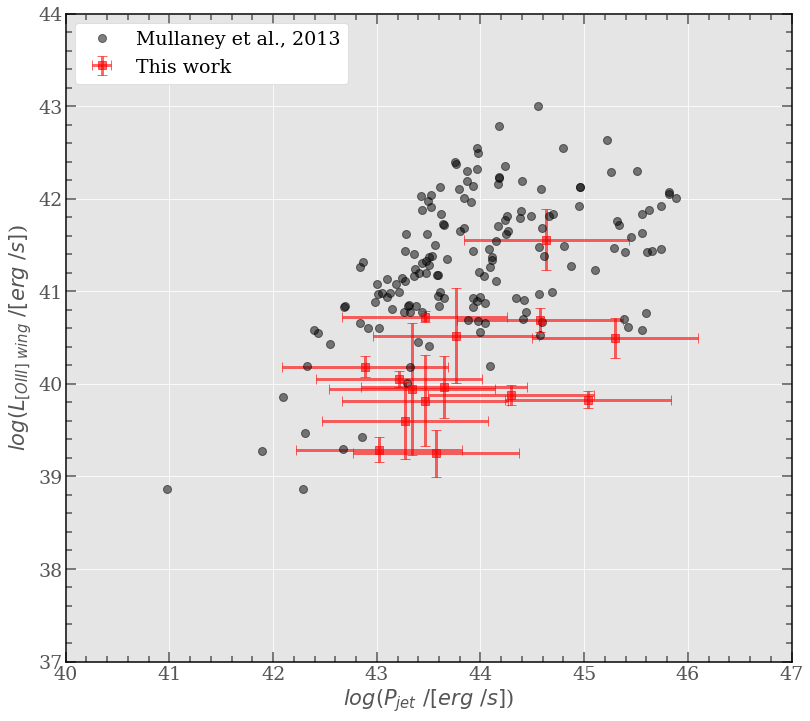

In [15]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
fig = plt.figure(figsize=(12,10)) 

ax1 = fig.add_axes([0.12, 0.07, 0.84, 0.9]) # main axes

ax1.plot(log_p_jet_mullaney,log_L_wing_mullaney,'ko',alpha=0.5,ms=8,label='Mullaney et al., 2013')
ax1.errorbar(log_P_jet,log_L_OIII_br,xerr=log_P_jet_err,yerr=log_L_OIII_br_err,alpha = 0.6,fmt = 'rs',ms=8,label='This work',linestyle="None",ecolor='r', elinewidth=3, capsize=5)
ax1.set_xlabel('$log(P_{jet}\  /[erg\ /s]$)',fontsize=21)
ax1.set_ylabel('$log(L_{[OIII]\ wing}\  /[erg\ /s]$)',fontsize=21)
ax1.set_ylim(37,44)
ax1.set_xlim(40,47)
ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.legend(facecolor='white', framealpha=1, fontsize=19, loc='upper left')

fig.savefig('LERG/Plots/P_jet_L_OIII.png',overwrite=True)

In [83]:
vel_core = data['vel_OIII']
vel_wing = data['vel_OIII_br']
vel_sigma_core = data['vel_sigma_OIII']
vel_sigma_wing = data['vel_sigma_OIII_br']
vel_sigma = np.sqrt((vel_sigma_core)**2 + (vel_sigma_wing)**2)
v_out = vel_wing - vel_core
hdu.close()

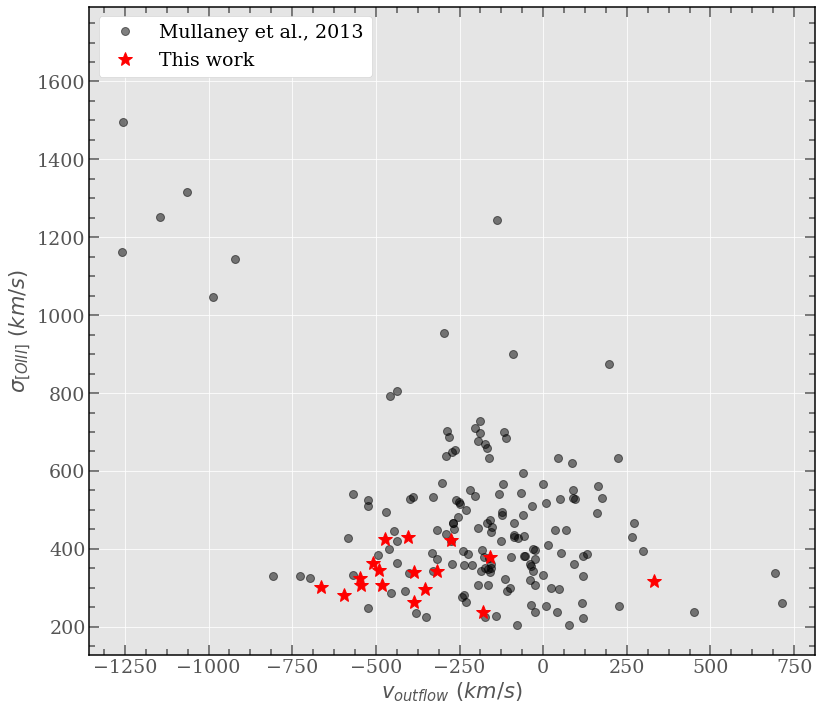

In [84]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
fig = plt.figure(figsize=(12,10)) 

ax1 = fig.add_axes([0.12, 0.07, 0.84, 0.9]) # main axes

ax1.plot(v_out_mullaney,vel_sigma_mullaney,'ko',alpha=0.5,ms=8,label='Mullaney et al., 2013')
ax1.plot(v_out,vel_sigma,'r*',ms=14,label='This work')

ax1.set_xlabel('$v_{outflow}\  (km/s)$',fontsize=21)
ax1.set_ylabel(r'$\sigma_{[OIII]}\ (km/s)$', fontsize=21)

ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.legend(facecolor='white', framealpha=1, fontsize=19, loc='upper left')

fig.savefig('LERG/Plots/Psigma_OIII_v_out.png',overwrite=True)

In [86]:
stats.spearmanr(log_P_jet,log_L_OIII_br)

SpearmanrResult(correlation=0.38080495356037153, pvalue=0.11898433684768554)

In [87]:
stats.spearmanr(log_p_jet_mullaney,log_L_wing_mullaney)

SpearmanrResult(correlation=0.48280206258056957, pvalue=1.0094742136315951e-10)

In [88]:
stats.spearmanr(log_P_jet,log_L_OIII)

SpearmanrResult(correlation=0.52941176470588236, pvalue=0.023858231279662807)

In [18]:
stats.spearmanr(log_p_jet_mullaney,log_L_OIII_mullaney)
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle

SpearmanrResult(correlation=0.49182266009852221, pvalue=4.784988703426688e-12)

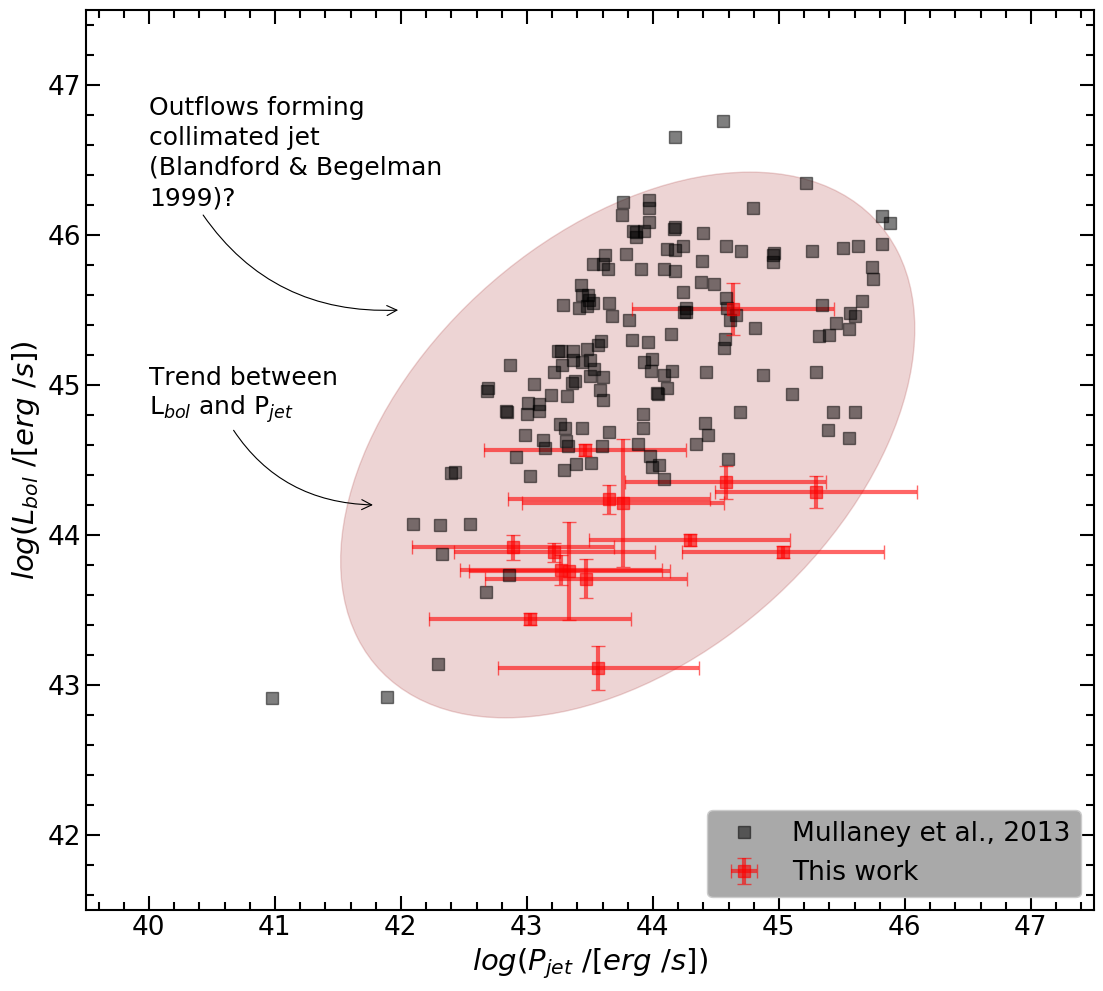

In [19]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
fig = plt.figure(figsize=(12,10)) 

ax1 = fig.add_axes([0.12, 0.07, 0.84, 0.9]) # main axes
ellipse=Ellipse(xy=(43.8,44.6),width=5,height=3,color='brown',alpha=0.2,angle=np.arctan(0.6)*(180/np.pi))
ax1.add_patch(ellipse)

ax1.plot(log_p_jet_mullaney,np.log10(3500)+log_L_OIII_mullaney,'ks',alpha=0.5,ms=8,label='Mullaney et al., 2013')
ax1.errorbar(log_P_jet,log_L_bol,xerr=log_P_jet_err,yerr=log_L_bol_err,alpha = 0.6,fmt = 'rs',ms=8,label='This work',linestyle="None",ecolor='r', elinewidth=3, capsize=5)
ax1.set_xlabel('$log(P_{jet}\  /[erg\ /s]$)',fontsize=21)
ax1.set_ylabel('$log(L_{bol}\  /[erg\ /s]$)',fontsize=21)
ax1.set_ylim(41.5,47.5)
ax1.set_xlim(39.5,47.5)
ax1.annotate(r'Trend between',xytext=(40,45),xy=(41.8,44.2),fontsize=18)
ax1.annotate(r'L$_{bol}$ and P$_{jet}$',xytext=(40,44.8),xy=(41.8,44.2),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=0.3'),fontsize=18)
ax1.annotate(r'Outflows forming',xytext=(40,46.8),xy=(42,45.5),fontsize=18)
ax1.annotate(r'collimated jet',xytext=(40,46.6),xy=(42,45.5),fontsize=18)
ax1.annotate(r'(Blandford & Begelman',xytext=(40,46.4),xy=(42,45.5),fontsize=18)
ax1.annotate(r'1999)?',xytext=(40,46.2),xy=(42,45.5),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=0.3'),fontsize=18)


ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.legend(facecolor='darkgray', framealpha=1, fontsize=19, loc='lower right')

fig.savefig('LERG/Plots/P_jet_L_bol.png',overwrite=True)

p_jet = np.append(log_p_jet_mullaney,log_P_jet)
l_bol = np.append(log_L_OIII_mullaney+np.log10(3500),log_L_bol)
stats.spearmanr(p_jet,l_bol)

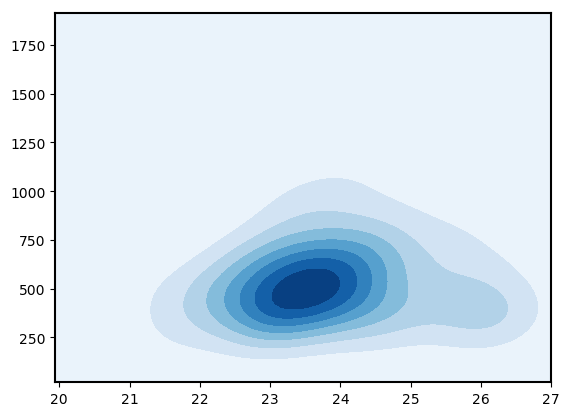

In [20]:
select = (fwhm_mullaney < 3500)

e = log_L_rad_mullaney[select]
f = fwhm_mullaney[select]
xmin = np.min(log_L_rad_mullaney[select])
xmax = 27#np.max(log_L_rad_mullaney[select])
ymin = 20#np.min(fwhm_mullaney[select])
ymax = np.max(fwhm_mullaney[select])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([e, f])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
plt.contourf(xx, yy, f, cmap='Blues')

In [21]:
from scipy.stats import gaussian_kde
# Calculate the point density
xy = np.vstack([log_L_rad_mullaney[select],fwhm_mullaney[select]])
z = gaussian_kde(xy)(xy)


In [22]:
select_moderate = (log_L_rad_mullaney>23) & (log_L_rad_mullaney<25)
print(np.mean(fwhm_mullaney[select_moderate]))

select_mod = (log_L_rad>23) & (log_L_rad<25)
np.mean(fwhm_OIII_tot[select_mod])

608.544770921


401.08124

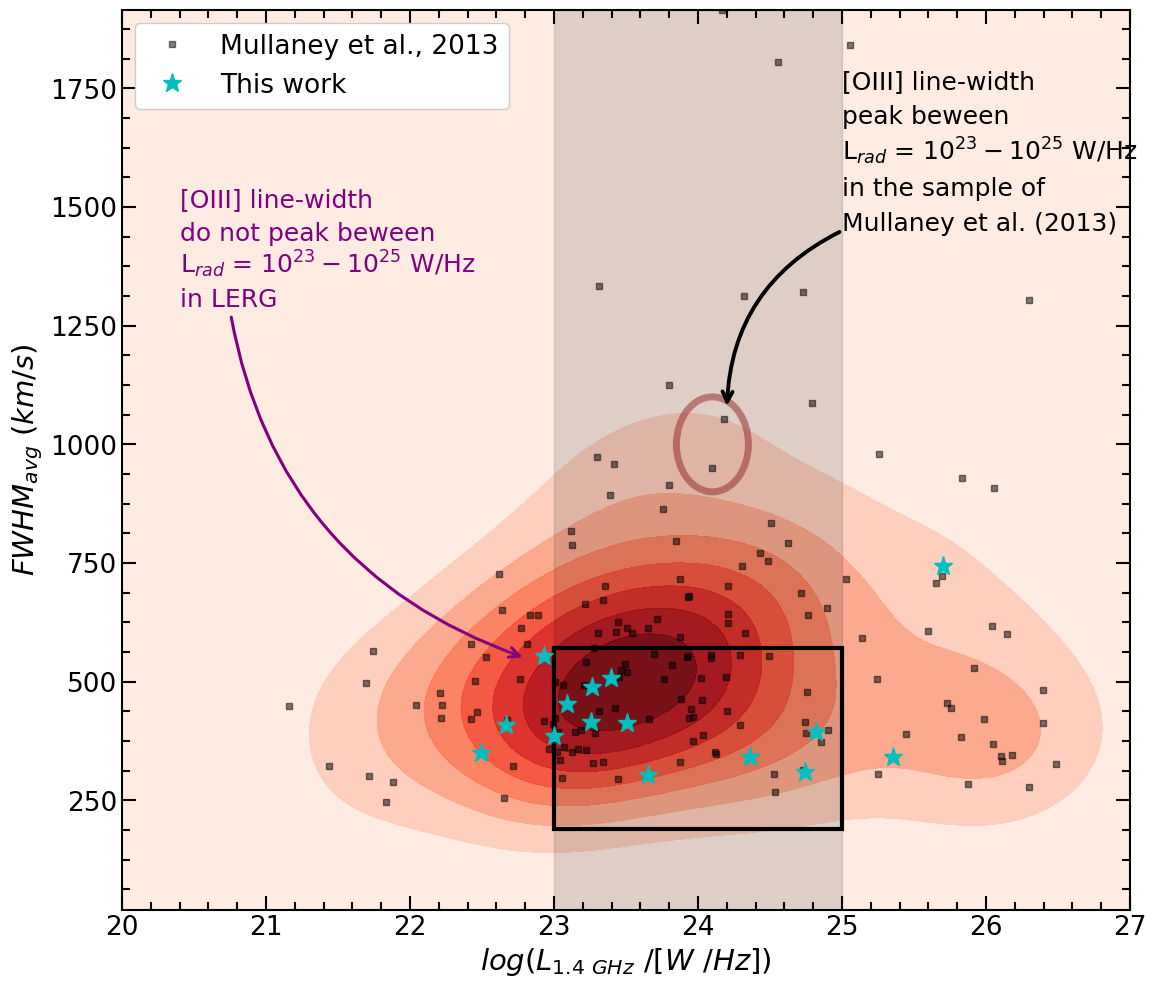

In [23]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'

fig = plt.figure(figsize=(12,10))
ax2 = fig.add_axes([0.12, 0.07, 0.84, 0.9]) # main axes

#plt.setp(ax2.get_yticklabels(), visible=False)

select = (fwhm_mullaney < 4500)

ax2.plot(log_L_rad_mullaney[select],fwhm_mullaney[select],'ks',alpha=0.5,ms=4,label='Mullaney et al., 2013')
ax2.plot(log_L_rad,fwhm_OIII_tot,"c*",ms=14,label='This work')
ax2.contourf(xx, yy, f, cmap='Reds',fill=None,alpha=0.95)

rectangle=Rectangle(xy=(23,190),width=2,height=380,color='k',lw=3,fill=None)
ax2.add_patch(rectangle)
ellipse=Ellipse(xy=(24.1,1000),width=0.5,height=200,color='brown',angle=0,fill=None,lw=5,alpha=0.5)
ax2.add_patch(ellipse)
ax2.set_xlabel('$log(L_{1.4\ GHz}\  /[W\ /Hz]$)',fontsize=21)
ax2.set_ylabel(r'$FWHM_{avg}\ (km/s)$', fontsize=21)
ax2.set_xlim(20,27)
ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax2.minorticks_on()
ax2.legend(facecolor='w', framealpha=1, fontsize=19, loc='upper left')
ax2.axvspan(23,25,color='k',alpha=0.12)
ax2.annotate(r'[OIII] line-width',xytext=(20.4,1500),xy=(23,550),fontsize=18,color='purple')
ax2.annotate(r'do not peak beween',xytext=(20.4,1430),xy=(23,550),fontsize=18,color='purple')
ax2.annotate(r'L$_{rad}$ = $10^{23}-10^{25}$ W/Hz',xytext=(20.4,1360),xy=(22.8,550),fontsize=18,color='purple')
ax2.annotate(r'in LERG',xytext=(20.4,1290),xy=(22.8,550),color='purple',arrowprops=dict(arrowstyle='->',color='purple',lw=2.2,connectionstyle='arc3,rad=0.3'),fontsize=18)

ax2.annotate(r'[OIII] line-width',xytext=(25,1750),xy=(25.3,1745),fontsize=18)
ax2.annotate(r'peak beween',xytext=(25,1675),xy=(24.8,1600),fontsize=18)
ax2.annotate(r'L$_{rad}$ = $10^{23}-10^{25}$ W/Hz',xytext=(25,1600),xy=(24.3,1320),fontsize=18)
ax2.annotate(r'in the sample of',xytext=(25,1525),xy=(24.3,1320),fontsize=18)
ax2.annotate(r'Mullaney et al. (2013)',xytext=(25,1450),xy=(23.6,1320),fontsize=18)
ax2.annotate(r'',xytext=(25,1450),xy=(24.2,1075),arrowprops=dict(arrowstyle='->',color='black',lw=2.8,connectionstyle='arc3,rad=0.3'),fontsize=18)


fig.savefig('LERG/Plots/FWHM_rad.png',overwrite=True)



In [96]:
stats.spearmanr(log_p_jet_mullaney,outflow_speed_mullaney)

SpearmanrResult(correlation=0.13583440759404664, pvalue=0.08677514750137183)

In [97]:
stats.spearmanr(log_P_jet,outflow_speed)

SpearmanrResult(correlation=0.1991744066047472, pvalue=0.42815803191920498)

In [101]:
r = 10**(log_P_jet - log_L_bol)
log_r = np.log10(r)
print (log_r)

[ 1.00789642 -0.42291641 -1.27716446 -0.66703415 -0.24073027 -0.8711586
 -0.4731102   0.03384019 -1.02910995 -0.58782959 -0.41959381  1.1493454
 -1.10453033  0.32395554 -0.49643707 -0.45261386  0.45603943  0.22648621]


In [103]:
#fwhm_OIII_tot
from matplotlib.colors import LogNorm

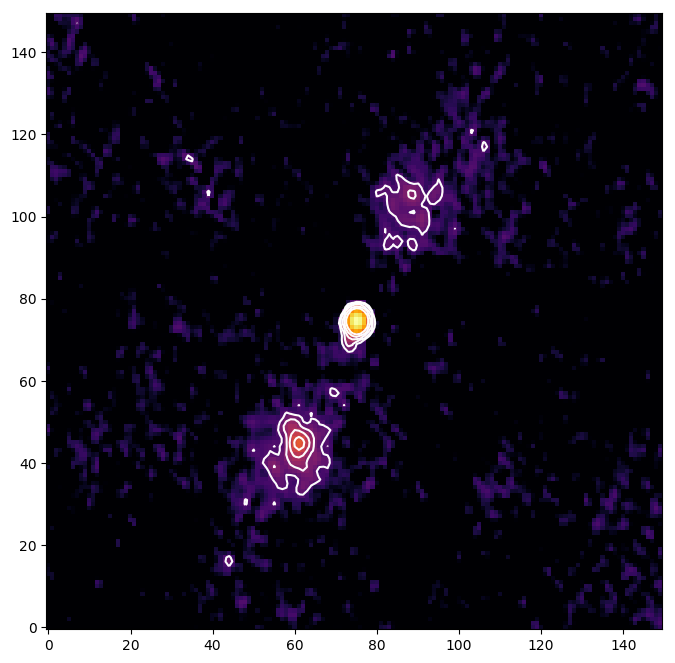

In [104]:
plt.style.use('default')
fig = plt.figure(figsize=(8,8))
hdu = fits.open('LERG/imaging/J232710-004157.fits')
image = hdu[0].data
image[image<0.0000001]=0.00000000001
plt.imshow(image,origin='lower',cmap='inferno',vmin=0.0001,vmax=0.073,norm=LogNorm())
plt.contour(image,levels=np.logspace(-3.3, -2, 5), colors='white', alpha=0.99)
fig.savefig('LERG/Plots/Overlay.png')

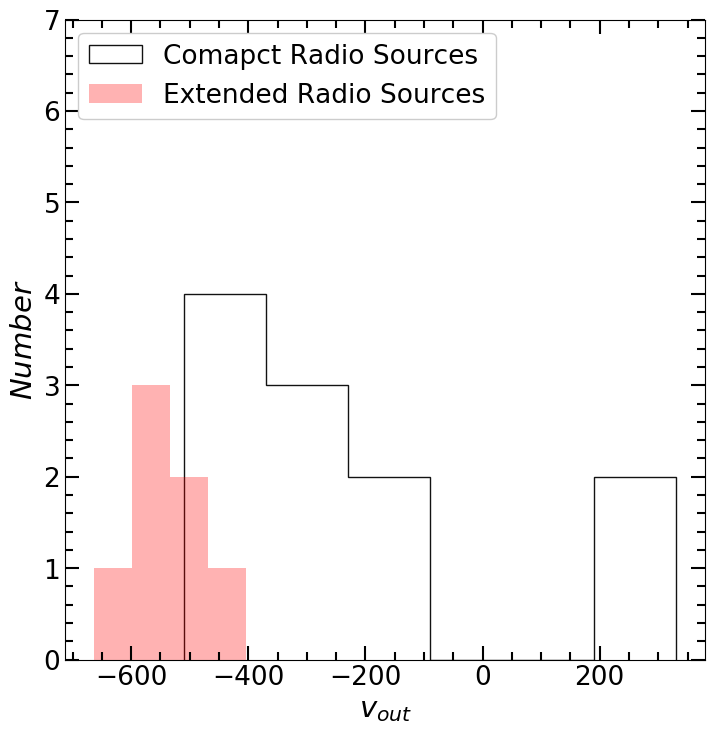

In [105]:


plt.style.use('default')
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.11, 0.11, 0.8, 0.8]) # main axes
ax1.hist(compact_v_out,bins=6,histtype='step',color='k',alpha=0.93,label='Comapct Radio Sources')
ax1.hist(extended_v_out,bins=4,histtype='stepfilled',color='r',alpha=0.3,label='Extended Radio Sources')
#ax1.axvline(x=0,color='k')

ax1.set_xlabel('$v_{out}$',fontsize=21)
ax1.set_ylabel(r'$Number$', fontsize=21)

ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.set_ylim(0,7)
#ax1.set_xlim(-2,2)
ax1.legend(facecolor='white', framealpha=1, fontsize=19, loc='upper left')

fig.savefig('LERG/Plots/v_out_hist.png')

In [106]:
np.mean(extended_fwhm_OIII_tot )

432.16241

In [107]:
fwhm_OIII_tot 

array([ 743.17114258,  182.86495972,  520.69335938,  452.20275879,
        553.43682861,  489.56939697,  393.73980713,  554.70947266,
        349.19473267,  413.14611816,  409.06933594,  341.92089844,
        414.93460083,  341.72927856,  384.9458313 ,  304.2322998 ,
        507.4463501 ,  308.86587524], dtype=float32)

In [108]:
print(log_P_jet)

[ 45.29438019  43.33639908  43.9790535   43.21746826  43.46769714
  44.63642502  43.96499252  44.36502075  42.88907242  43.64958954
  43.02221298  45.03375626  43.46067047  44.29048538  43.27106476
  43.760952    43.5678215   44.57723999]


In [109]:
print(log_L_bol)

[ 44.28648376  43.75931549  45.25621796  43.88450241  43.70842743
  45.50758362  44.43810272  44.33118057  43.91818237  44.23741913
  43.44180679  43.88441086  44.56520081  43.96652985  43.76750183
  44.21356583  43.11178207  44.35075378]


In [110]:
np.log10(R_edd)

array([-2.18704724, -2.74347806, -2.13717818, -2.11742616, -2.74405408,
       -2.15337062, -2.08952522, -2.10727668, -2.10915184, -2.45055771,
       -2.78230453, -2.39197779, -2.15672302, -2.15899134, -2.60764122,
       -2.06590843, -2.88483143, -2.06777191], dtype=float32)

In [111]:
P_jet_fr1 = [45.294,44.636,43.461,43.271]
fwhm_fr1 = [743.17,489.57,414.93,384.95]

L_bol_fr2 = [43.884,43.966,44.351]
fwhm_fr2 = [341.921,341.729,308.866]

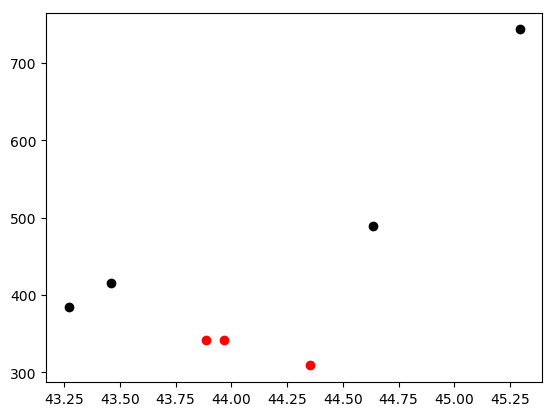

In [112]:
plt.plot(P_jet_fr1,fwhm_fr1,'ko')
plt.plot(L_bol_fr2,fwhm_fr2,'ro')

In [113]:
log_eta = log_P_jet -log_L_bol+np.log10(R_edd)

In [114]:
print(log_eta)

[-1.17915082 -3.16639447 -3.41434264 -2.78446031 -2.98478436 -3.02452922
 -2.56263542 -2.0734365  -3.1382618  -3.0383873  -3.20189834 -1.24263239
 -3.26125336 -1.8350358  -3.10407829 -2.51852226 -2.428792   -1.84128571]


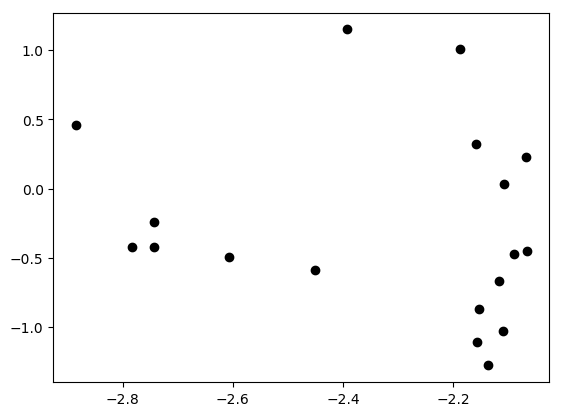

In [115]:
plt.plot(np.log10(R_edd),log_r,'ko')

In [117]:
v_out
from matplotlib.colors import LogNorm

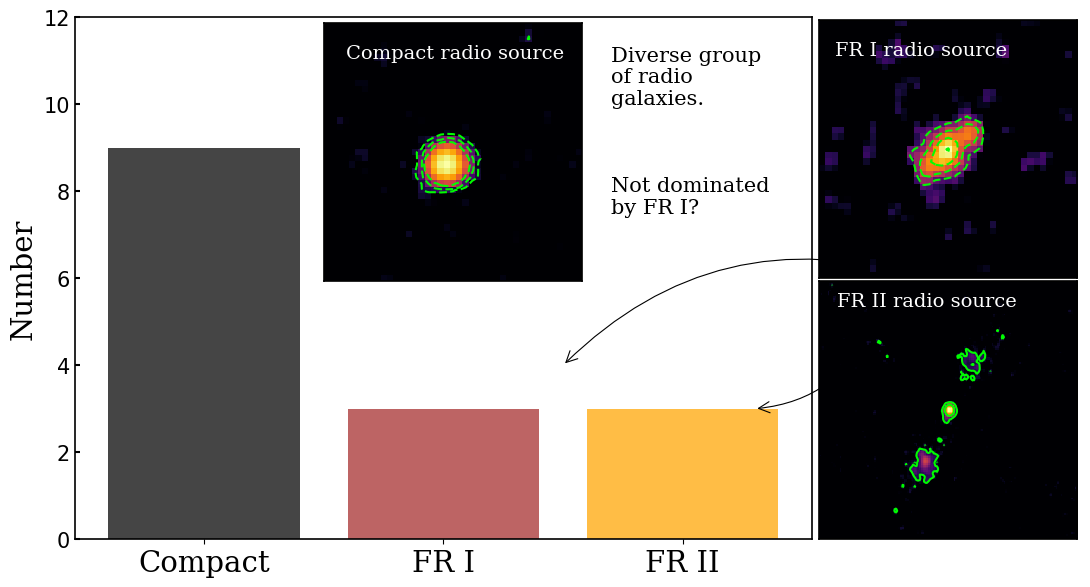

In [31]:
[x0,y0]=[76,76]
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.edgecolor'] = 'k'
fig = plt.figure(figsize=(11, 6)) 

ax1 = fig.add_axes([0.06,0.1,0.67,0.87])
ax2 = fig.add_axes([0.225,0.53,0.358,0.43])
ax3 = fig.add_axes([0.675,0.10,0.358,0.43])
ax4 = fig.add_axes([0.675,0.535,0.358,0.43])

#plt.setp(ax1.get_xticklabels(), visible=False)
ax1.grid(False)
height = [9, 3, 3]
bars = ['Compact', 'FR I', 'FR II']
y_pos =  np.arange(len(bars))
ax1.bar(y_pos, height,color=['k','brown','orange'],alpha=0.73)
ax1.set_xticks(y_pos)
ax1.set_ylabel('Number',fontname="Serif",fontsize=21)
ax1.set_xticklabels(bars,fontname="Serif",fontsize=21)
#ax1.set_yticklabels(fontsize=21)
ax1.tick_params(axis='y',which='both',direction='in',width=1.5,labelsize=15)
ax1.annotate(r'',xy=(1.5,4),xytext=(3,6),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=0.3'),fontsize=20)
ax1.annotate(r'',xy=(2.3,3),xytext=(2.8,5),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=-0.3'),fontsize=20)
ax1.text(1.7,11,r'Diverse group',color='k',fontname="Serif",fontsize=15)
ax1.text(1.7,10.5,r'of radio',color='k',fontname="Serif",fontsize=15)
ax1.text(1.7,10,r'galaxies.',color='k',fontname="Serif",fontsize=15)
ax1.text(1.7,8,r'Not dominated',color='k',fontname="Serif",fontsize=15)
ax1.text(1.7,7.5,r'by FR I?',color='k',fontname="Serif",fontsize=15)
ax1.set_ylim(0,12)


ax2.grid(False)
hdu = fits.open('LERG/imaging/J153457+233013.fits')
data = hdu[0].data
hdu.close()
data = data[y0-20:y0+21,x0-20:x0+21]
data[data<0.000001]=0.000001
ax2.imshow(data,origin='lower',vmin=0.0003,vmax=np.max(data),norm=LogNorm(),cmap='inferno')
ax2.contour(data,levels=np.logspace(-3.2, -2, 3), colors='Lime',linestyles='dashed', alpha=0.99)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.text(3,35,r'Compact radio source',fontname="Serif",color='w',fontsize=14)


ax3.grid(False)
hdu = fits.open('LERG/imaging/J232710-004157.fits')
data = hdu[0].data
data[data<0.000001]=0.000001
ax3.imshow(data,origin='lower',vmin=0.0003,vmax=np.max(data),norm=LogNorm(),cmap='inferno')
ax3.contour(data,levels=np.logspace(-3.3, -2, 2), colors='Lime',alpha=0.99)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.text(10,135,r'FR II radio source',fontname="Serif",color='w',fontsize=14)


ax4.grid(False)
hdu = fits.open('LERG/imaging/J142041+015930.fits')
data = hdu[0].data
hdu.close()
[x0,y0] = [76,76]
data = data[y0-20:y0+21,x0-20:x0+21]
data[data<0.000001]=0.000001
ax4.imshow(data,origin='lower',vmin=0.0002,vmax=np.max(data),norm=LogNorm(),cmap='inferno')
ax4.contour(data,levels=np.logspace(-3.3, -2.4, 4), colors='Lime', linestyles='dashed', alpha=0.99)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.text(2,35,r'FR I radio source',fontname="Serif",color='w',fontsize=14)
fig.savefig('LERG/Plots/Bar plot.png',overwrite=True)



In [35]:
hdu = fits.open('Radio Loud Table.fits')
data_tot = hdu[1].data
data= data_tot[data_tot['L'] == 1]

print (len(data))

flux_OIII_5007 = data['OIII_5007_FLUX']
flux_OIII_5007_err = data['OIII_5007_FLUX_ERR']

SN_OIII_5007 = flux_OIII_5007/flux_OIII_5007_err

flux_Hb = data['H_BETA_FLUX']
flux_Hb_err = data['H_BETA_FLUX_ERR']

SN_Hb = flux_Hb/flux_Hb_err

flux_Ha = data['H_ALPHA_FLUX']
flux_Ha_err = data['H_ALPHA_FLUX_ERR']

SN_Ha = flux_Ha/flux_Ha_err

flux_NII_6584 = data['NII_6584_FLUX']
flux_NII_6584_err = data['NII_6584_FLUX_ERR']

SN_NII_6584 = flux_NII_6584/flux_NII_6584_err

flux_SII_6717 = data['SII_6717_FLUX']
flux_SII_6717_err = data['SII_6717_FLUX_ERR']

SN_SII_6717 = flux_SII_6717/flux_SII_6717_err

flux_SII_6731 = data['SII_6731_FLUX']
flux_SII_6731_err = data['SII_6731_FLUX_ERR']

SN_SII_6731 = flux_SII_6731/flux_SII_6731_err

z = data['z_1']
length = len(flux_OIII_5007)

vel_sigma_star = data['V_DISP']

ra = data['RA']
dec = data['DEC']

radio_flux = data['SNVSS']
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
D_L = cosmo.luminosity_distance(z)
dist = D_L.to(u.cm)
log_radio_power = np.log10(4*np.pi) + 2*np.log10(dist.value) + np.log10(radio_flux) - 33

log_lum_OIII = np.log10(4*np.pi) + 2*np.log10(dist.value) + np.log10(flux_OIII_5007) - 17
lum_OIII = 10**(log_lum_OIII)
lum_bol = 3500*lum_OIII
ratio_edd = edd_ratio(log_lum_OIII,vel_sigma_star)
log_p_jet = 0.75*log_radio_power + 26.02
select = (ratio_edd!=np.nan)
r_edd = ratio_edd[~np.isnan(ratio_edd)]
R_edd = (r_edd[~np.isinf(r_edd)])
R_eddington = R_edd[R_edd>0]
R_eddington = R_eddington[R_eddington<0.01]
len(R_eddington)

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10


9863


/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in log10
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


8546

In [36]:
quantity_1 = np.log10(flux_OIII_5007/flux_Hb) - np.log10(flux_NII_6584/flux_Ha)
quantity_2 = np.log10(flux_OIII_5007/flux_Hb) - np.log10((flux_SII_6717+flux_SII_6731)/flux_Ha)
SN = data['OIII_5007_FLUX']/data['OIII_5007_FLUX_ERR']

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/

In [63]:
select = (quantity_1 > 0) & (quantity_1 < 0.7) & (quantity_2 > 0) & (quantity_2 < 0.9) & (SN_OIII_5007 > 3) & (SN_Hb > 3) & (SN_Ha > 3) & (SN_NII_6584 > 3) & (SN_SII_6717 > 3) & (SN_SII_6731 >3) #& (ratio_edd<0.01) & (ratio_edd!=np.inf)#:
log_P_j = log_p_jet[select]
l = ratio_edd[select]
select_l = (l<0.01) & (l!=np.inf)
l = l[select_l]
log_P_j = log_P_j[select_l]
len(l)

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


803

In [38]:
Hb_OIII_ratio = flux_Hb/flux_OIII_5007
Hb_lum = (10**(log_L_OIII_br - 41.0))
P_kin = ((outflow_speed)**3)*Hb_lum

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [39]:
def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
    
    w80 = ((w80_spec)/5006.8)*(c/(1+z))
    return w80

cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
cor_popt_err = np.array([amp_OIII5007_err,amp_OIII5007_br_err,vel_OIII_err,vel_sigma_OIII_err,vel_OIII_br_err,vel_sigma_OIII_br_err])


In [43]:
w80_MC1 = np.zeros((15,1))
w80_err_MC = np.zeros((15,1))

for i in range(15):
    cor_popt = np.array([amp_OIII5007[i],amp_OIII5007_br[i],vel_OIII[i],vel_sigma_OIII[i],vel_OIII_br[i],vel_sigma_OIII_br[i]])
    cor_popt_err = np.array([amp_OIII5007_err[i],amp_OIII5007_br_err[i],vel_OIII_err[i],vel_sigma_OIII_err[i],vel_OIII_br_err[i],vel_sigma_OIII_br_err[i]])
    redshift = Z[i]
    w80 = line_shape_par(redshift,4980,5030,cor_popt)
    par_MC = np.zeros((1,100))
    for l in range(100):
        w80_MC = line_shape_par(redshift,4980,5030,np.random.normal(cor_popt,cor_popt_err))
        par_MC[:,l] = w80_MC
    w80_error_MC = np.nanstd(par_MC,1)
    w80_err_MC[i,:] = w80_error_MC
    w80_MC1[i,:] = w80
print (w80_MC1,w80_err_MC)

[[ 936.54704947]
 [ 712.28798892]
 [ 737.50102106]
 [ 954.25114044]
 [ 698.13112123]
 [ 791.70141732]
 [ 768.07450446]
 [ 720.63950471]
 [ 755.58241176]
 [ 773.57870002]
 [ 852.69553489]
 [ 807.61872391]
 [ 584.99850158]
 [ 799.19713976]
 [ 812.33056345]] [[ 203.89980935]
 [ 343.33194982]
 [ 102.63723964]
 [ 213.9043965 ]
 [ 131.43463624]
 [ 102.11528916]
 [ 400.82585271]
 [  56.06722508]
 [  95.44923574]
 [ 164.28811257]
 [ 224.55526782]
 [ 192.65316227]
 [ 200.91701305]
 [ 101.9053149 ]
 [ 109.36622705]]


In [53]:
log_r_edd = np.log10(R_edd_Mainak)
print (len(log_r_edd))
log_MBH=M_BH(log_L_OIII,log_r_edd)
log_M_BH_mullaney_err = 0.3*(log_M_BH_mullaney/log_M_BH_mullaney)
print (log_M_BH_mullaney)

15
[  9.61345089   8.93878477   9.75310918   8.87307271  10.14547295
  10.38881922  10.46120776   9.97115091   9.80021644  10.30785598
   9.58950585   8.93210006  10.38689169   9.44702798   9.91450144
   9.53399628   9.37174659   8.97474699   9.94080789   9.23031393
  10.00351438   9.55053352   9.2039334   10.20330004   9.9092198
   9.90392034   8.45398476  10.14300722   9.28820573   8.66961319
   9.35704323   9.17919121  10.14407122   8.00357881   9.6849541
  10.25236603   9.36447261   9.87563535   9.87796127   9.75229336
   9.28259153   9.61068651   9.70498968   9.0555209    9.80325487
   9.45527554   9.15960106   9.68485329   9.83746288   8.9101415
   8.60605381   9.23475507   9.31403028  10.09186657  10.56293266
   9.89552165   8.96666562   9.46892718  10.08015105   9.31226216
  10.87936351  10.14083343   9.68567884   8.28977969  10.52582043
   9.34321376   9.18185488   9.84786553   9.57823757   9.38706106
   9.95602505   9.90441896   9.22979692   8.9122475    8.5864904
   9.025510

In [54]:
wing_lum=np.append(log_L_wing_mullaney,log_L_OIII_br)
mbh = np.append(log_M_BH_mullaney,log_MBH)
mbh_err = 0.3*(mbh/mbh)
bol_lum = np.append(log_L_OIII_mullaney+np.log10(3500),log_L_bol)
stats.spearmanr(mbh,bol_lum)
a, b = np.polyfit(bol_lum, mbh, deg=1)
bol_lum = np.arange(40,48,0.1)

print(a,b)

y_est = a * bol_lum + b
y_err = bol_lum.std() * np.sqrt(1/len(bol_lum) +(bol_lum - bol_lum.mean())**2 / np.sum((bol_lum - bol_lum.mean())**2))

len(y_est)

0.878499585421 -30.2384266521


80

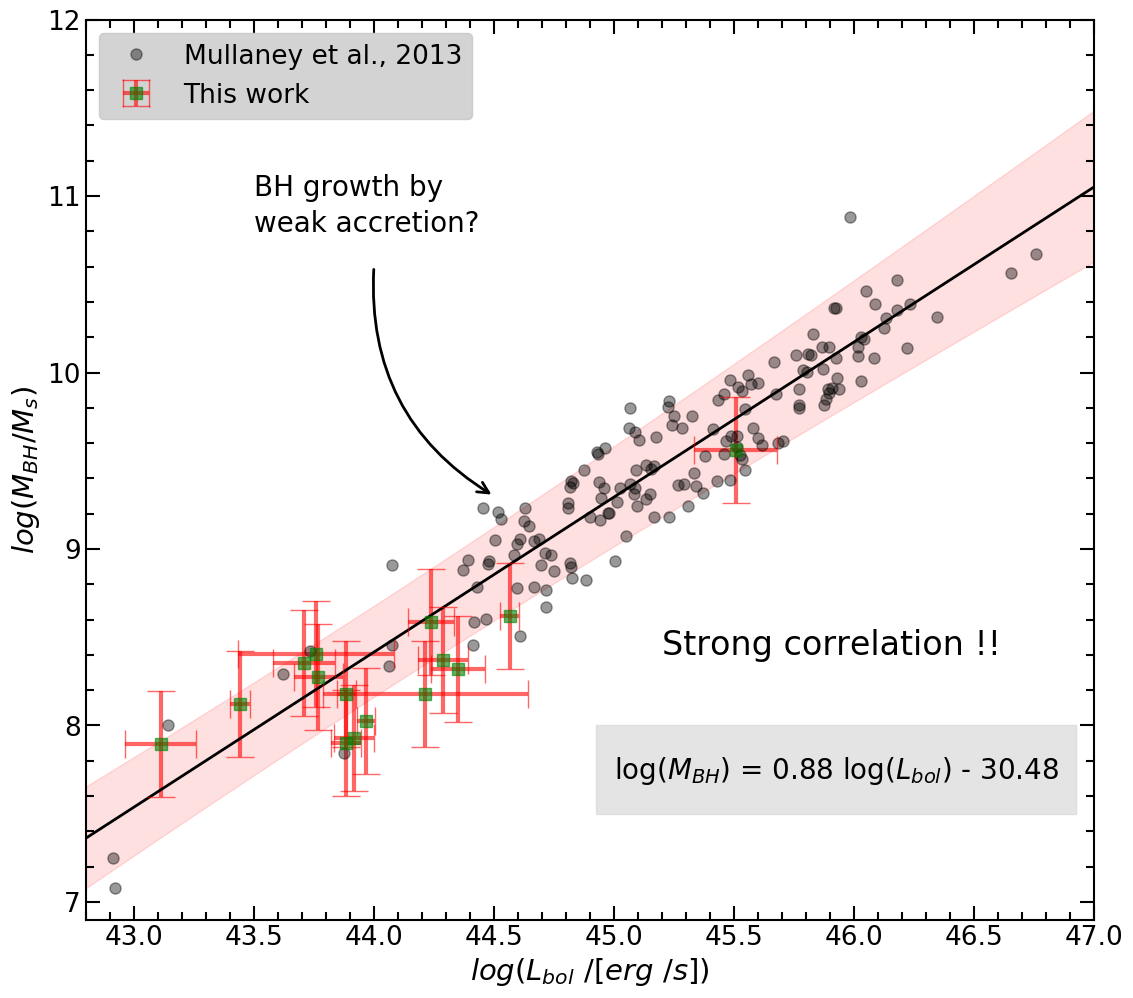

In [55]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
fig = plt.figure(figsize=(12,10)) 

ax1 = fig.add_axes([0.12, 0.07, 0.84, 0.9]) # main axes

ax1.plot(np.log10(3500)+log_L_OIII_mullaney,log_M_BH_mullaney,'ko',alpha=0.4,ms=8,label='Mullaney et al., 2013')
ax1.plot(bol_lum, y_est,'k-',lw=2)
ax1.fill_between(bol_lum, y_est - y_err, y_est + y_err,alpha=0.12,color='r')
ax1.errorbar(log_L_bol,log_MBH,xerr=log_L_bol_err,yerr=0.3*(log_MBH/log_MBH),alpha = 0.6,fmt = 'gs',ms=8,label='This work',linestyle="None",ecolor='r', elinewidth=3, capsize=10)
ax1.set_xlabel('$log(L_{bol}\  /[erg\ /s]$)',fontsize=21)
ax1.set_ylabel('$log(M_{BH}/M_{s}$)',fontsize=21)
ax1.set_ylim(6.9,12)
ax1.set_xlim(42.8,47)
ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.legend(facecolor='lightgray', framealpha=1, fontsize=19, loc='upper left')
ax1.annotate(r'BH growth by',xytext=(43.5,11),xy=(44.5,9.3),fontsize=20)
ax1.annotate(r'weak accretion?',xytext=(43.5,10.8),xy=(44.5,9.3),fontsize=20)
ax1.annotate(r'',xytext=(44,10.6),xy=(44.5,9.3),arrowprops=dict(arrowstyle='->',color='black',lw=2,connectionstyle='arc3,rad=0.3'),fontsize=20)
ax1.annotate(r'Strong correlation !!',xytext=(45.2,8.4),xy=(44.3,8),fontsize=24)
ax1.annotate(r'log($M_{BH}$) = 0.88 log($L_{bol}$) - 30.48',xytext=(45.0,7.7),xy=(44.3,8),fontsize=20)
r=Rectangle(xy=(44.925,7.5),width=2.0,height=0.5,color='lightgray',alpha=0.6,angle=0)
ax1.add_patch(r)

fig.savefig('LERG/Plots/LMBH_L_bol.png',overwrite=True)

In [56]:
stats.spearmanr(log_L_OIII_mullaney,log_M_BH_mullaney)

SpearmanrResult(correlation=0.92130844954881053, pvalue=1.0459900002548962e-66)

In [57]:
wing_lum=np.append(log_L_wing_mullaney,log_L_OIII_br)
mbh = np.append(log_M_BH_mullaney,log_MBH)
mbh_err = 0.3*(mbh/mbh)

a, b = np.polyfit(mbh, wing_lum, deg=1)
mbh = np.arange(5,12,0.1)

print(a,b)

y_est = a * mbh+ b
y_err = mbh.std() * np.sqrt(1/len(mbh) +(mbh - mbh.mean())**2 / np.sum((mbh - mbh.mean())**2))

len(y_est)

0.956469836 32.2150610445


70

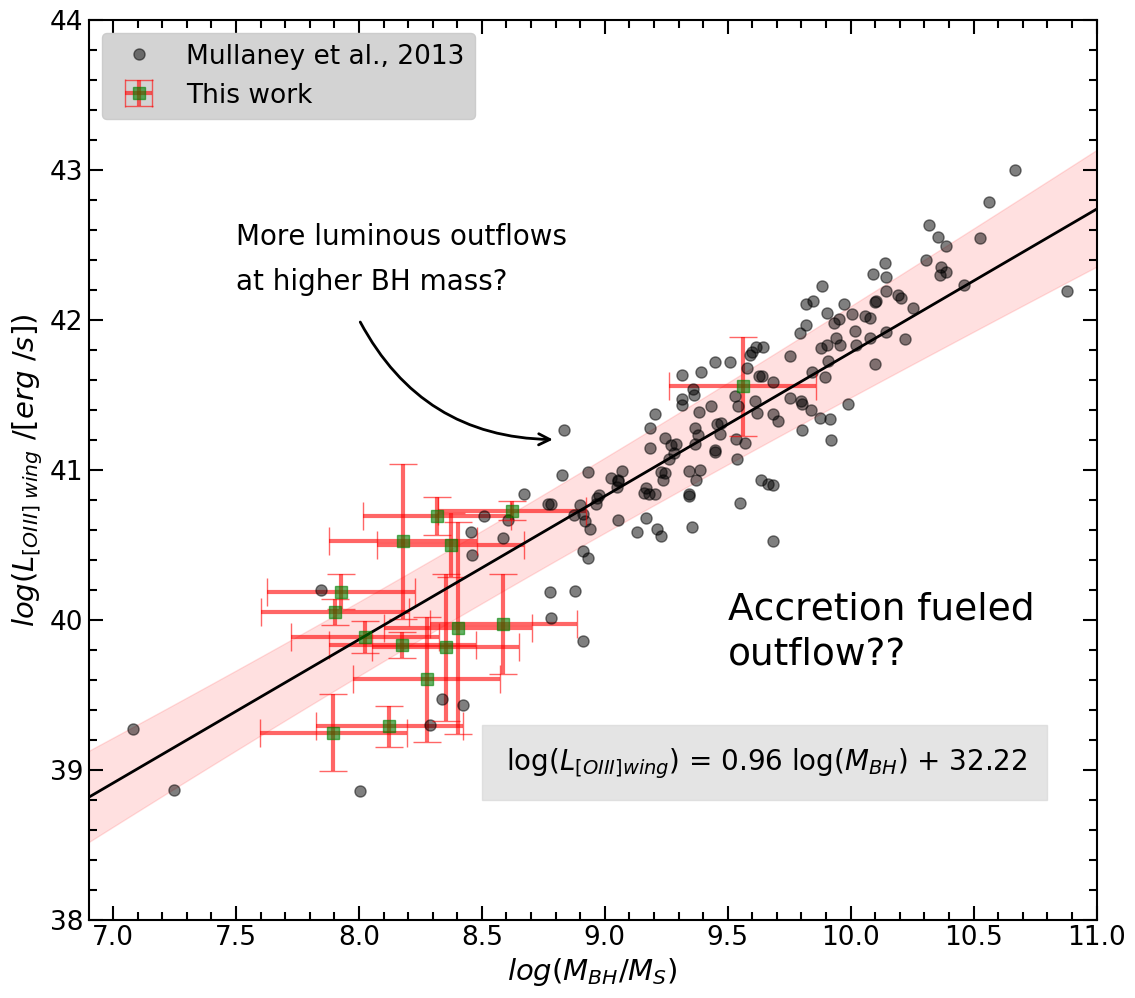

In [58]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
fig = plt.figure(figsize=(12,10)) 

ax1 = fig.add_axes([0.12, 0.07, 0.84, 0.9]) # main axes

ax1.plot(log_M_BH_mullaney,log_L_wing_mullaney,'ko',alpha=0.5,ms=8,label='Mullaney et al., 2013')
ax1.errorbar(log_MBH,log_L_OIII_br,yerr=log_L_OIII_br_err,xerr=0.3*(log_MBH/log_MBH),alpha = 0.6,fmt = 'gs',ms=8,label='This work',linestyle="None",ecolor='r', elinewidth=3, capsize=10)
ax1.fill_between(mbh, y_est - y_err, y_est + y_err,alpha=0.12,color='r')
ax1.plot(mbh,y_est,lw=2,color='k')
ax1.set_xlabel('$log(M_{BH}/M_{S}$)',fontsize=21)
ax1.set_ylabel('$log(L_{[OIII]\ wing}\  /[erg\ /s]$)',fontsize=21)
ax1.set_xlim(6.9,11)
ax1.set_ylim(38,44)
ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.legend(facecolor='lightgray', framealpha=1, fontsize=19, loc='upper left')
ax1.annotate(r'More luminous outflows',xytext=(7.5,42.5),xy=(8.8,41),fontsize=20)
ax1.annotate(r'at higher BH mass?',xytext=(7.5,42.2),xy=(8.8,41),fontsize=20)
ax1.annotate(r'',xytext=(8,42),xy=(8.8,41.2),arrowprops=dict(arrowstyle='->',color='black',lw=2,connectionstyle='arc3,rad=0.3'),fontsize=20)
ax1.annotate(r'Accretion fueled',xytext=(9.5,40),xy=(10,39),fontsize=27)
ax1.annotate(r'outflow??',xytext=(9.5,39.7),xy=(10,39),fontsize=27)
ax1.annotate(r'log($L_{[OIII] wing}$) = 0.96 log($M_{BH}$) + 32.22',xytext=(8.6,39),xy=(9.6,41),fontsize=20)
r=Rectangle(xy=(8.5,38.8),width=2.3,height=0.5,color='lightgray',alpha=0.6,angle=0)
ax1.add_patch(r)
fig.savefig('LERG/Plots/L_wing_MBH.png',overwrite=True)

In [59]:
stats.spearmanr(log_M_BH_mullaney,log_L_wing_mullaney)

SpearmanrResult(correlation=0.89457693659908588, pvalue=3.8460431224413616e-57)

In [84]:
X = np.log10(l)


803


/usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


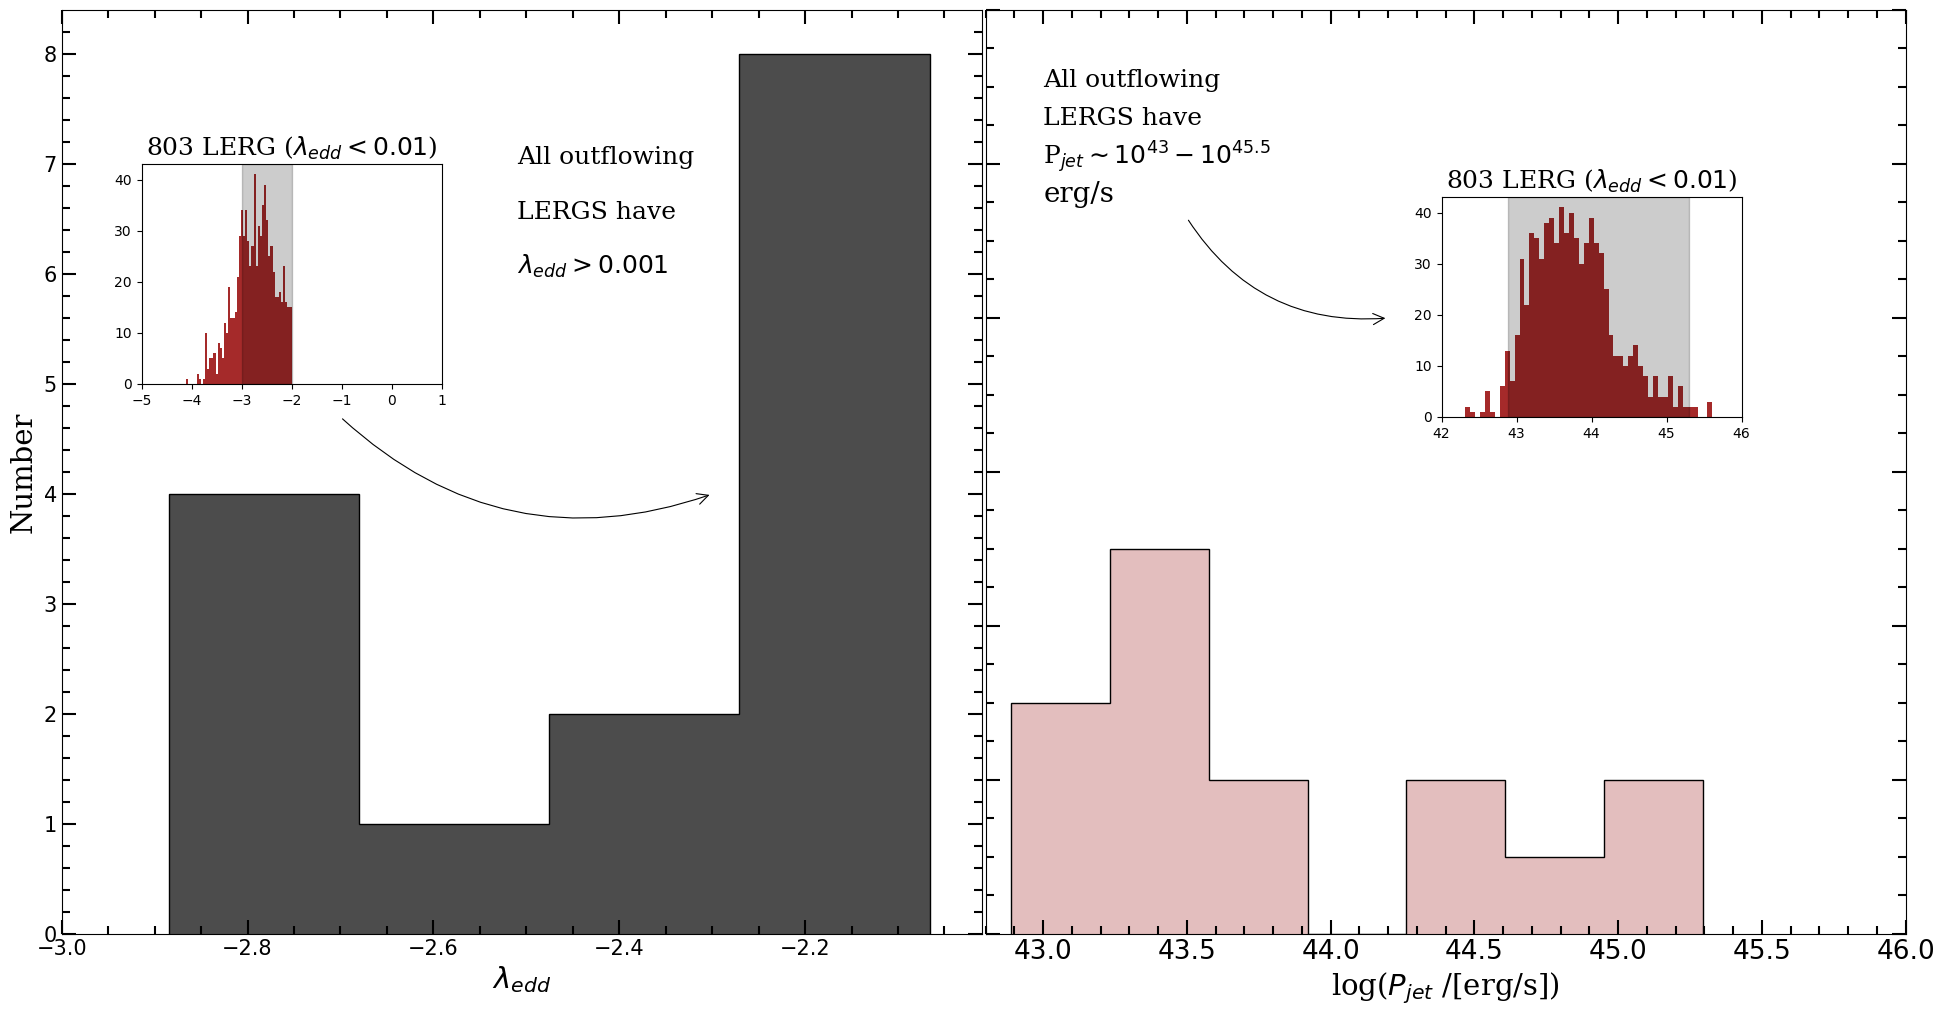

In [87]:

plt.style.use('default')
fig = plt.figure(figsize=(20,11))
ax1 = fig.add_axes([0.06,0.1,0.46,0.84])
ax2 = fig.add_axes([0.1, 0.6, 0.15, 0.2]) # main axes
ax3 = fig.add_axes([0.522,0.1,0.46,0.84])
ax4 = fig.add_axes([0.75, 0.57, 0.15, 0.2]) # main axes
plt.setp(ax3.get_yticklabels(), visible=False)


ax1.hist(np.log10(R_edd),bins=4,color='k',alpha=0.7)
ax1.hist(np.log10(R_edd),bins=4,histtype="step",color='k')


ax1.set_xlabel(r'$\lambda_{edd}$',fontname="Serif",fontsize=21)
ax1.set_ylabel(r'Number',fontname="Serif", fontsize=21)

ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.legend(facecolor='white', framealpha=1, fontsize=19, loc='upper left')
ax1.set_xlim(-3,-2.01)
ax1.annotate(r'All outflowing',fontname="Serif",xytext=(-2.51,7),xy=(-2.3,4),fontsize=18)
ax1.annotate(r'LERGS have',fontname="Serif",xytext=(-2.51,6.5),xy=(-2.3,4),fontsize=18)
ax1.annotate(r'$\lambda_{edd}>0.001$',fontname="Serif",xytext=(-2.51,6.0),xy=(-2.3,4),fontsize=18)
ax1.annotate(r'',xytext=(-2.7,4.7),xy=(-2.3,4),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=0.3'),fontsize=20)

ax2.hist(X,bins=50,color='brown')
ax2.set_xlim(-5,1)
ax2.axvspan(-3,-2,color='k',alpha=0.2)
ax2.set_title('803 LERG ($\lambda_{edd}<0.01$)',fontname="Serif",fontsize=18)
#fig.savefig('LERG/Plots/edd_ratio_hist_poster.png')

X = np.log10(l)
print(len(log_P_j))
plt.style.use('default')
ax3.hist(log_P_jet,bins=7,color='brown',alpha=0.3)
ax3.hist(log_P_jet,bins=7,color='k',histtype='step')

ax3.set_xlabel(r'log($P_{jet}$ /[erg/s])',fontname="Serif",fontsize=21)
#ax3.set_ylabel(r'Number',fontname="Serif",fontsize=21)

ax3.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax3.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax3.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax3.minorticks_on()
ax3.legend(facecolor='white', framealpha=1, fontsize=19, loc='upper left')
ax3.set_xlim(42.8,46)
ax3.set_ylim(0,12)
ax3.annotate(r'All outflowing',fontname="Serif",xytext=(43,11),xy=(44.3,8),fontsize=18)
ax3.annotate(r'LERGS have',fontname="Serif",xytext=(43,10.5),xy=(44,7.5),fontsize=18)
ax3.annotate(r'P$_{jet}\sim 10^{43}-10^{45.5}$',fontname="Serif",xytext=(43,10.0),xy=(44.3,7),fontsize=18)
ax3.annotate(r'erg/s',fontname="Serif",xytext=(43,9.5),xy=(44.5,6.5),fontsize=20)
ax3.annotate(r'',fontname="Serif",xytext=(43.5,9.3),xy=(44.2,8),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=0.3'),fontsize=20)

ax4.hist(log_P_j,bins=50,color='brown')
ax4.set_xlim(42,46)
ax4.axvspan(np.min(log_P_jet),np.max(log_P_jet),color='k',alpha=0.2)
ax4.set_title('803 LERG ($\lambda_{edd}<0.01$)',fontname="Serif",fontsize=18)


fig.savefig('LERG/Plots/joint_hist.png')


In [ ]:
select_Ed = (r_edd>0) & (r_edd<0.3)
plt.axvline(x=0.043,color='k')
plt.hist(r_edd[select_Ed],bins=100)


plt.style.use('default')

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['font.family']='Serif'
csfont = {'fontname':'Times New Roman'}

fig = plt.figure(figsize=(9,7)) 

ax1 = fig.add_axes([0.105, 0.125, 0.855, 0.865]) # main axes

cm = plt.cm.RdBu

#n, bins, patches = ax1.hist(log_L_Hb_blr_mullaney_good, 100,density=1,edgecolor='k',lw=0.2, color='green')
#for i, p in enumerate(patches):
#    plt.setp(p, 'facecolor', cm(i/500)) # notice the i/25

ax1.hist(m,bins=100,color='brown',label='Mullaney et al. (2013)',alpha=0.3)
ax1.hist(m,bins=100,histtype='step',color='k',alpha=0.3)

plt.axvline(x=41.16,color='k',ls='--',lw=1.2,alpha=0.9999)
ax1.annotate('HE 0040-1105',xy=(41.15,6),xytext=(38,800),fontsize=18)
ax1.annotate('$L_{H \\beta \  BLR}$',xy=(41.15,6),xytext=(38,740),fontsize=18)
ax1.annotate(r'$=10^{41.16}$ erg/s',xy=(41.15,4),xytext=(38,680),fontsize=18)
ax1.annotate('',xy=(41.15,200),xytext=(39,660),arrowprops=dict(arrowstyle= '->',color='black',lw=1.2,connectionstyle='arc3,rad=0.3'),fontsize=18)


ax1.set_xlabel('log($L_{H \\beta \  BLR}\  /[erg\ s^{-1}])$',fontsize=21)
ax1.set_ylabel('Number of sources',fontsize=21)
ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=19)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=10)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=6)
ax1.minorticks_on()
ax1.set_xlim(37.5,43.5)

ax1.legend(facecolor='lightgray', framealpha=1, fontsize=15, loc='upper left')
fig.savefig('/home/rickeythecat/Downloads/Outflow_paper1/LHb_histogram.png',overwrite=True)


In [ ]:
log_L_bol_mullaney = np.log10(L_bol_mullaney) + np.log10(3500)

In [149]:
vel_out = vel_OIII_br - vel_OIII
v_out_err = np.sqrt((vel_OIII_err)**2+(vel_OIII_br_err)**2)
v_max = np.abs(vel_out) + 2*np.abs(vel_sigma_OIII_br)

par_MC = np.zeros((19,100))
for l in range (100):
    popt_MC = np.abs(np.random.normal(vel_out,v_out_err))+2*np.abs(np.random.normal(vel_sigma_OIII_br,vel_sigma_OIII_br_err))
    par_MC[:,l] = popt_MC
par_err = np.nanstd(par_MC,1)
print (v_max,par_err)

[  581.26702881  1230.46984863   533.36785889  1042.48242188   881.8671875
   871.83850098  1035.11938477  1167.6315918    964.05999756  1065.35217285
   962.48742676  1101.3581543    965.65661621  1080.27880859   490.84442139
  1063.1607666    950.58465576  1072.9173584   1185.8737793 ] [ 197.50230152  268.55505764  322.45986344  431.8578338   350.17299723
  120.56936785  280.63774282  163.17910872  423.71951606  118.83703511
   72.86947153  114.11727036  274.43359052  346.62544612  327.82493661
  229.15482083  134.45103682  211.61900063  133.93602853]


In [151]:
w80_MC1 = np.zeros((19,1))
w80_err_MC = np.zeros((19,1))

for i in range(19):
    cor_popt = np.array([amp_OIII5007[i],amp_OIII5007_br[i],vel_OIII[i],vel_sigma_OIII[i],vel_OIII_br[i],vel_sigma_OIII_br[i]])
    cor_popt_err = np.array([amp_OIII5007_err[i],amp_OIII5007_br_err[i],vel_OIII_err[i],vel_sigma_OIII_err[i],vel_OIII_br_err[i],vel_sigma_OIII_br_err[i]])
    redshift = Z[i]
    w80 = line_shape_par(redshift,4980,5030,cor_popt)
    par_MC = np.zeros((1,100))
    for l in range(100):
        w80_MC = line_shape_par(redshift,4980,5030,np.random.normal(cor_popt,cor_popt_err))
        par_MC[:,l] = w80_MC
    w80_error_MC = np.nanstd(par_MC,1)
    w80_err_MC[i,:] = w80_error_MC
    w80_MC1[i,:] = w80
print (w80_MC1,w80_err_MC)

[[  630.69020614]
 [  978.08448887]
 [  399.05019157]
 [ 1057.59287916]
 [  666.1932462 ]
 [  735.56858743]
 [  680.48037288]
 [  684.30674259]
 [  718.38960384]
 [  693.45275658]
 [  698.24954951]
 [  762.35035272]
 [  822.23786112]
 [  846.16057645]
 [  411.2415503 ]
 [  796.0802487 ]
 [  609.52356522]
 [  763.87304341]
 [  812.33056345]] [[ 137.97095552]
 [ 215.89220824]
 [ 231.60024737]
 [ 356.7544573 ]
 [ 327.1846148 ]
 [  89.61799497]
 [ 126.25567825]
 [  91.14927612]
 [ 413.79558962]
 [ 118.15724189]
 [  50.32871622]
 [  94.97313259]
 [ 187.73770882]
 [ 188.27909999]
 [ 262.65871803]
 [ 203.57158773]
 [ 299.78158252]
 [ 165.29293657]
 [ 107.38294215]]
